<a href="https://colab.research.google.com/github/zawarudobngdev/learning_machine_learning/blob/master/Handwritten%20Digit%20Classification%20Model/Initial_Handwritten_Digit_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Handwritten Digit Classification Model

#### A model made for the Izycode Machine Learning Internship Program

This is a model that recognizes handwritten digits (0-9) using the MNIST dataset, a foundational task in image classification. It accurately classifies images of handwritten digits, setting the stage for more advanced image
recognition applications.

I have separeted this task into 3 steps across 3 notebooks to better showcase the developing process.

This is the initial notebook where I began the development.

 Here we load de mnist dataset and plot the first 9 images.

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


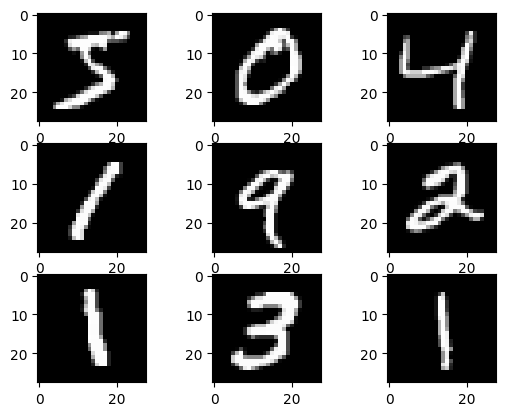

In [ ]:
# loading the mnist dataset
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt

# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()

# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

# plot first few images
for i in range(9):
 # define subplot
 plt.subplot(330 + 1 + i)
 # plot raw pixel data
 plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))

# show the figure
plt.show()

We import everything we will need

In [ ]:
# cnn model for mnist
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD

## Loading Dataset

We know some things about the dataset.

For example, each image only contains a single hand-drawn digit, the images all have the same square size of 28x28 pixels, and the images are all grayscale.

So, we can load the images and reshape the data arrays to have a single color channel.

We also know that there are 10 classes and that classes are represented as unique integers.

We can use a one hot encoding for the class element of each sample, transforming the integer into a 10 element binary vector with a 1 for the index of the class value, and 0 values for all other classes. We can achieve this with the to_categorical() utility function.

Now, the load_dataset() function implements these behaviors and can be used to load the dataset.

In [ ]:
# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = mnist.load_data()

	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))

	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

## Preparing Pixel Data

A good start is to normalize the pixel values of grayscale images, e.g. rescale them to the range [0,1]. This involves first converting the data type from unsigned integers to floats, then dividing the pixel values by the maximum value.

The prep_pixels() function below implements these behaviors and is provided with the pixel values for both the train and test datasets that will need to be scaled.

In [ ]:
# scale pixels
def prep_pixels(train, test):
 # convert from integers to floats
 train_norm = train.astype('float32')
 test_norm = test.astype('float32')

 # normalize to range 0-1
 train_norm = train_norm / 255.0
 test_norm = test_norm / 255.0

 # return normalized images
 return train_norm, test_norm

## Defining Model

Next, we define a convolutional neural network model for the problem.

The model has two main aspects: the feature extraction comprised of convolutional and pooling layers, and the classifier that will make a prediction.

For the convolutional, we start with a single convolutional layer with a small filter size (3,3) and a modest number of filters (32) followed by a max pooling layer. The filter maps can then be flattened to provide features to the classifier.

We can increase the depth of the feature extractor part of the model, following a VGG-like pattern of adding more convolutional and pooling layers with the same sized filter, while increasing the number of filters. In this case, we will add a double convolutional layer with 64 filters each, followed by another max pooling layer.

Given that the problem is a multi-class classification task, we will require an output layer with 10 nodes in order to predict the probability distribution of an image belonging to each of the 10 classes. This requires the use of a softmax activation function.

Between the feature extractor and the output layer, we can add a dense layer to interpret the features, in this case with 100 nodes.

All layers will use the ReLU activation function and the He weight initialization scheme, both best practices.

We will use a conservative configuration for the optimizer with a learning rate of 0.01 and a momentum of 0.9. The categorical cross-entropy loss function will be optimized, which is suitable for multi-class classification, and we will monitor the classification accuracy metric.

The define_model() function below will define and return this model.

In [ ]:
# define cnn model
def define_model():
 model = Sequential()
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
 model.add(MaxPooling2D((2, 2)))
 model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
 model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
 model.add(MaxPooling2D((2, 2)))
 model.add(Flatten())
 model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
 model.add(Dense(10, activation='softmax'))
 # compile model
 opt = SGD(learning_rate=0.01, momentum=0.9)
 model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
 return model

## Evaluating the Model

After the model is defined, we need to evaluate it.

The model will be evaluated using five-fold cross-validation. The value of k=5 was chosen to provide a baseline for both repeated evaluation and to not be so large as to require a long running time. Each test set will be 20% of the training dataset, or about 12,000 examples, close to the size of the actual test set for this problem.

The training dataset is shuffled prior to being split, and the sample shuffling is performed each time, so that any model we evaluate will have the same train and test datasets in each fold, providing an apples-to-apples comparison between models.

We will train the model for a modest 10 epochs with a default batch size of 32 examples. The test set for each fold will be used to evaluate the model both during each epoch of the training run, so that we can later create learning curves, and at the end of the run, so that we can estimate the performance of the model. We will keep track of the resulting history from each run, as well as the classification accuracy of the fold.

The evaluate_model() function below implements these behaviors, taking the training dataset as arguments and returning a list of accuracy scores and training histories that can be later summarized.

In [ ]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

# Presenting Results

Once the model has been evaluated, we can present the results.

There are two key aspects to present: the diagnostics of the learning behavior of the model during training and the estimation of the model performance. These can be implemented using separate functions.

First, the diagnostics involve creating a line plot showing model performance on the train and test set during each fold of the k-fold cross-validation. It is a good way for getting an idea of whether a model is overfitting, underfitting, or has a good fit.

We will create a single figure with two subplots, one for loss and one for accuracy.

The summarize_diagnostics() function below creates and shows this plot given the collected training histories.

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		plt.subplot(2, 1, 1)
		plt.title('Cross Entropy Loss')
		plt.plot(histories[i].history['loss'], color='blue', label='train')
		plt.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		plt.subplot(2, 1, 2)
		plt.title('Classification Accuracy')
		plt.plot(histories[i].history['accuracy'], color='blue', label='train')
		plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	plt.show()

The classification accuracy scores collected during each fold can be summarized by calculating the mean and standard deviation. We will also summarize the distribution of scores by creating and showing a box and whisker plot.

The summarize_performance() function below implements this for a given list of scores collected during model evaluation.

In [ ]:
# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# box and whisker plots of results
	plt.boxplot(scores)
	plt.show()

# Test Harness

We need a function that will drive the test harness. This involves calling all of the define functions.

Running the example prints the classification accuracy for each fold of the cross-validation process. This is helpful to get an idea that the model evaluation is progressing.

We can see the accuracy is over 99%. Good results.

Next, a diagnostic plot is shown, giving insight into the learning behavior of the model across each fold.

In this case, we can see that the model generally achieves a good fit, with no clear signs of overfitting. The plots may even suggest that further training epochs could be helpful.

Next, a summary of the model performance is calculated. We can see that the model has an estimated skill of about 99%.

Finally, a box and whisker plot is created to summarize the distribution of accuracy scores.

> 99.008
> 99.100
> 99.000
> 99.092
> 99.008


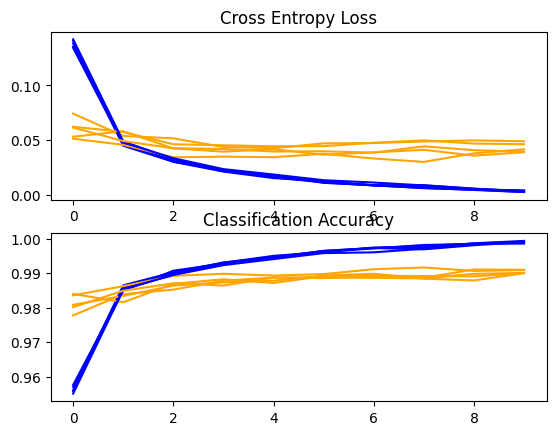

Accuracy: mean=99.042 std=0.044, n=5


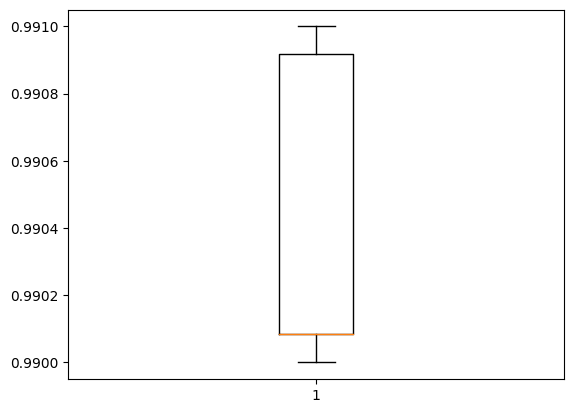

In [ ]:
# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# evaluate model
	scores, histories = evaluate_model(trainX, trainY)
	# learning curves
	summarize_diagnostics(histories)
	# summarize estimated performance
	summarize_performance(scores)

# entry point, run the test harness
run_test_harness()